In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.5.1/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetB_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetB_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Month, Begin_Time, Compl_Time, Peak_Time, Trop_Peak_Time = [], [], [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
        Month.append(Find_Month(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Trop_Peak_Time.append(Datetime(ET_DF["Trop Peak Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    Data_DF["Month"] = Month
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Trop Peak Time"] = Trop_Peak_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Find_Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lon_Bins = Create_Bins(-100,20,5)
Lat_Bins = Create_Bins(0,60,5)

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Function For Creating Cumulative Distribution
def Cum_Dist(DF, Var, Min, Max, Bin_Width):
    Values = Create_Bins(Min, Max, Bin_Width)
    Count = numpy.zeros(len(Values))
    Length = len(DF[(DF[Var] >= Min) & (DF[Var] <= Max)])
    for i in range(len(Count)):
        Range = DF[(DF[Var] >= Min) & (DF[Var] <= Values[i])]
        Count[i] = len(Range)
    Density = Count / Length
    return (Values, Density)

In [11]:
# Function For Applying SLP Bounds
def ET_SLP_Bounds(Control_ET, RCP45_ET, RCP85_ET, Begin):
# Define SLP Bound For ET Begin and ET Complete
    Begin_SLP_Bound = 1008
    Compl_SLP_Bound = 1008
# Apply Bounds
    if Begin == True:
        Control_ET_Begin = Control_ET[Control_ET["ET Begin SLP"] <= Begin_SLP_Bound]
        RCP45_ET_Begin = RCP45_ET[RCP45_ET["ET Begin SLP"] <= Begin_SLP_Bound]
        RCP85_ET_Begin = RCP85_ET[RCP85_ET["ET Begin SLP"] <= Begin_SLP_Bound]
        return (Control_ET_Begin, RCP45_ET_Begin, RCP85_ET_Begin)
    else:
        Control_ET_Compl = Control_ET[Control_ET["ET Complete SLP"] <= Compl_SLP_Bound]
        RCP45_ET_Compl = RCP45_ET[RCP45_ET["ET Complete SLP"] <= Compl_SLP_Bound]
        RCP85_ET_Compl = RCP85_ET[RCP85_ET["ET Complete SLP"] <= Compl_SLP_Bound]
        return (Control_ET_Compl, RCP45_ET_Compl, RCP85_ET_Compl)

In [12]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Horiz, \
    Begin_Min, Compl_Min, Begin_Max, Compl_Max, Bin_Width, Label_Width, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,8))
#
# Plot ET Initiation
    Axis = Fig.add_subplot(1,2,1)
    Var1 = "ET Begin " + Var
    Control_ET_Begin, RCP45_ET_Begin, RCP85_ET_Begin = ET_SLP_Bounds(Control_ET, RCP45_ET, RCP85_ET, True)
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_ET_Begin, Var1, Begin_Min, Begin_Max, Bin_Width)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_ET_Begin, Var1, Begin_Min, Begin_Max, Bin_Width)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_ET_Begin, Var1, Begin_Min, Begin_Max, Bin_Width)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP4.5', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP8.5', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP4.5', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP8.5', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Axis, 0, Var, Horiz, Begin_Min, Begin_Max, Label_Width, str("ET Begin " + Var_Label))
#
# Legend
    pyplot.legend(loc=4, fontsize=15)
#
# Plot ET Completion
    Axis = Fig.add_subplot(1,2,2)
    Var2 = "ET Complete " + Var
    Control_ET_Compl, RCP45_ET_Compl, RCP85_ET_Compl = ET_SLP_Bounds(Control_ET, RCP45_ET, RCP85_ET, False)
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_ET_Compl, Var2, Compl_Min, Compl_Max, Bin_Width)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_ET_Compl, Var2, Compl_Min, Compl_Max, Bin_Width)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_ET_Compl, Var2, Compl_Min, Compl_Max, Bin_Width)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Axis, 1, Var, Horiz, Compl_Min, Compl_Max, Label_Width, str("ET Complete " + Var_Label))
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [13]:
# Formatting Based on Variable
def ET_Cum_Dist_Formatting(Axis, Num, Var, Horiz, Min, Max, Width, Title):
# x Ticks and Lims
    x_Ticks = Create_Bins(Min, Max, Width)
# y Ticks and Lims
    if Horiz == False:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
    else:
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(Create_Bins(0,1,0.125))
        pyplot.xlim(0,1)
#
# Labels and Title
    if Var == "Lat":
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
    elif Var == "Lon":
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        pyplot.xlabel("Longitude", fontsize=18)
    elif Var == "SLP" or Var == "SLP(hPa)":
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        pyplot.xlabel("Sea Level Pressure (hPa)", fontsize=18)
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Letter Labels
    Letter_Label(Axis, Num)

In [14]:
# Create Subsets For Storm Phase Cumulative Distributions
def Phase_Subsets(Data):
    Subset_0 = Data[Data["SLP(hPa)"] <= 1008].reset_index()
    Subset_Trop = Subset_0[Subset_0["Storm Phase"] == "Tropical"]
    Subset_Trans = Subset_0[Subset_0["Storm Phase"] == "Transition"]
    Subset_Extra = Subset_0[Subset_0["Storm Phase"] == "Extratropical"]
    return (Subset_0, Subset_Trop, Subset_Trans, Subset_Extra)

In [15]:
# Create Function to Plot Storm Phase Cumulative Distributions
def Phase_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Var, Var_Label, Horiz, \
    All_Min, Trop_Min, Trans_Min, Extra_Min, All_Max, Trop_Max, Trans_Max, Extra_Max, \
    Bin_Width, Label_Width, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,16))
#
# Create Subsets
    Control_All, Control_Trop, Control_Trans, Control_Extra = Phase_Subsets(Control_Data)
    RCP45_All, RCP45_Trop, RCP45_Trans, RCP45_Extra = Phase_Subsets(RCP45_Data)
    RCP85_All, RCP85_Trop, RCP85_Trans, RCP85_Extra = Phase_Subsets(RCP85_Data)
#
# Plot All Storms
    Axis = Fig.add_subplot(2,2,1)
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_All, Var, All_Min, All_Max, Bin_Width)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_All, Var, All_Min, All_Max, Bin_Width)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_All, Var, All_Min, All_Max, Bin_Width)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP4.5', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP8.5', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP4.5', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP8.5', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Axis, 0, Var, Horiz, All_Min, All_Max, Label_Width, str(Var_Label + " (All)"))
#
# Legend
    pyplot.legend(loc=4, fontsize=15)
#
# Plot Tropical Phase
    Axis = Fig.add_subplot(2,2,2)
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_Trop, Var, Trop_Min, Trop_Max, Bin_Width)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_Trop, Var, Trop_Min, Trop_Max, Bin_Width)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_Trop, Var, Trop_Min, Trop_Max, Bin_Width)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP4.5', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP8.5', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP4.5', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP8.5', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Axis, 1, Var, Horiz, Trop_Min, Trop_Max, Label_Width, str(Var_Label + " (Tropical)"))
#
# Plot Extratropical Phase
    Axis = Fig.add_subplot(2,2,3)
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_Trans, Var, Trans_Min, Trans_Max, Bin_Width)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_Trans, Var, Trans_Min, Trans_Max, Bin_Width)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_Trans, Var, Trans_Min, Trans_Max, Bin_Width)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Axis, 2, Var, Horiz, Trans_Min, Trans_Max, Label_Width, str(Var_Label + " (Transitioning)"))
#
# Plot Extratropical Phase
    Axis = Fig.add_subplot(2,2,4)
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_Extra, Var, Extra_Min, Extra_Max, Bin_Width)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_Extra, Var, Extra_Min, Extra_Max, Bin_Width)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_Extra, Var, Extra_Min, Extra_Max, Bin_Width)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Axis, 3, Var, Horiz, Extra_Min, Extra_Max, Label_Width, str(Var_Label + " (Extratropical)"))
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [16]:
# Create Subsets For Phase Space Parameter Cumulative Distributions
def Param_Subsets(Data, Subset_Var):
    Subset_0 = Data[Data["SLP(hPa)"] <= 1008].reset_index()
    if Subset_Var == "SLP(hPa)":
        Subset_1 = Subset_0
        Subset_2 = Subset_0[(Subset_0[Subset_Var] > 0) & (Subset_0[Subset_Var] <= 1000)].reset_index()
        Subset_3 = Subset_0[(Subset_0[Subset_Var] > 0) & (Subset_0[Subset_Var] <= 990)].reset_index()
        Subset_4 = Subset_0[Subset_0[Subset_Var] <= 980].reset_index()
        Subset_Labels = ["SLP ≤ 1008hPa", "SLP ≤ 1000hPa", "SLP ≤ 990hPa", "SLP ≤ 980hPa"]
    elif Subset_Var == "Lat":
        Subset_1 = Subset_0[Subset_0[Subset_Var] >= 40].reset_index()
        Subset_2 = Subset_0[(Subset_0[Subset_Var] >= 35) & (Subset_0[Subset_Var] < 40)].reset_index()
        Subset_3 = Subset_0[(Subset_0[Subset_Var] >= 30) & (Subset_0[Subset_Var] < 35)].reset_index()
        Subset_4 = Subset_0[Subset_0[Subset_Var] < 30].reset_index()
        Subset_Labels = ["Lat ≥ 40N", "Lat 35~40N", "Lat 30~35N", "Lat < 30N"]
    elif Subset_Var == "Month":
        Subset_1 = Subset_0[(Subset_0[Subset_Var] >= 1) & (Subset_0[Subset_Var] <= 3)].reset_index()
        Subset_2 = Subset_0[(Subset_0[Subset_Var] >= 4) & (Subset_0[Subset_Var] <= 6)].reset_index()
        Subset_3 = Subset_0[(Subset_0[Subset_Var] >= 7) & (Subset_0[Subset_Var] <= 9)].reset_index()
        Subset_4 = Subset_0[(Subset_0[Subset_Var] >= 10) & (Subset_0[Subset_Var] <= 12)].reset_index()
        Subset_Labels = ["Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"]
    Subsets = [Subset_1, Subset_2, Subset_3, Subset_4]
    return (Subsets, Subset_Labels)

In [17]:
# Create Function to Plot Phase Space Parameter Cumulative Distributions
def Param_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Subset_Var, \
    B_Min, B_Max, B_Bin_Width, B_Label_Width, VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width, Savefig, Figname):
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Create Subsets
    Control_Subsets, Subset_Labels = Param_Subsets(Control_Data, Subset_Var)
    RCP45_Subsets, Subset_Labels = Param_Subsets(RCP45_Data, Subset_Var)
    RCP85_Subsets, Subset_Labels = Param_Subsets(RCP85_Data, Subset_Var)
    N = len(Subset_Labels)
#
# Create Axes
    Fig = pyplot.figure(figsize=(20,20))
    Axes = Fig.subplots(N,3, sharex=False, sharey=False)
    for i in range(N):
#
# Apply Cumulative Distribution Function
        Control_Sorted, Control_Density = Cum_Dist(Control_Subsets[i], "B", B_Min, B_Max, B_Bin_Width)
        RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_Subsets[i], "B", B_Min, B_Max, B_Bin_Width)
        RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_Subsets[i], "B", B_Min, B_Max, B_Bin_Width)
# Plot B
        Axes[i][0].plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axes[i][0].plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axes[i][0].plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
        Axes[i][0].plot([15,15], [0,1], color='black', linewidth=1.8, linestyle='--')
# Formatting Based on Variable
        Param_Cum_Dist_Formatting(Axes, i, 0, "B", Subset_Var, Subset_Labels[i], B_Min, B_Max, B_Label_Width)
#
# Legend
        if i == 0:
            Axes[i][0].legend(loc=4, fontsize=15)
#
# Apply Cumulative Distribution Function
        Control_Sorted, Control_Density = Cum_Dist(Control_Subsets[i], "VLT", VLT_Min, VLT_Max, VLT_Bin_Width)
        RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_Subsets[i], "VLT", VLT_Min, VLT_Max, VLT_Bin_Width)
        RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_Subsets[i], "VLT", VLT_Min, VLT_Max, VLT_Bin_Width)
# Plot VLT
        Axes[i][1].plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axes[i][1].plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axes[i][1].plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
        Axes[i][1].plot([0,0], [0,1], color='black', linewidth=1.8, linestyle='--')
# Formatting Based on Variable
        Param_Cum_Dist_Formatting(Axes, i, 1, "VLT", Subset_Var, Subset_Labels[i], VLT_Min, VLT_Max, VLT_Label_Width)
#
# Apply Cumulative Distribution Function
        Control_Sorted, Control_Density = Cum_Dist(Control_Subsets[i], "VUT", VLT_Min, VLT_Max, VLT_Bin_Width)
        RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_Subsets[i], "VUT", VLT_Min, VLT_Max, VLT_Bin_Width)
        RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_Subsets[i], "VUT", VLT_Min, VLT_Max, VLT_Bin_Width)
# Plot VUT
        Axes[i][2].plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axes[i][2].plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axes[i][2].plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
        Axes[i][2].plot([0,0], [0,1], color='black', linewidth=1.8, linestyle='--')
# Formatting Based on Variable
        Param_Cum_Dist_Formatting(Axes, i, 2, "VUT", Subset_Var, Subset_Labels[i], VLT_Min, VLT_Max, VLT_Label_Width)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [18]:
# Formatting Based on Variable
def Param_Cum_Dist_Formatting(Axes, i, j, Var, Subset_Var, Subset_Label, Min, Max, Width):
# x Ticks and Lims
    x_Ticks = Create_Bins(Min, Max, Width)
# y Ticks and Lims
    Axes[i][j].set_xticks(x_Ticks)
    Axes[i][j].set_xlim(Min, Max)
    Axes[i][j].set_yticks(Create_Bins(0,1,0.125))
    Axes[i][j].set_ylim(0,1)
#
# Labels and Title
    if j == 0:
        Axes[i][j].set_ylabel("Cumulative Frequency Density", fontsize=15)
    if i == 3:
        Axes[i][j].set_xlabel(Var, fontsize=18)
    Title = Var + ' (' + Subset_Label + ')'
    Axes[i][j].set_title(Title, fontsize=25)
#
# Gridlines
    Axes[i][j].grid(linewidth=0.5, color='silver', linestyle='-')
#
# Letter Labels
    Letter_Label(Axes[i][j], i*3+j)

In [19]:
# Letter Labels
def Letter_Label(Axis, Plot):
    Fig_Labels = ['(a)','(b)','(c)','(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
    Axis.text(0.05, 0.95, str(Fig_Labels[int(Plot)]), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':24},color='black')

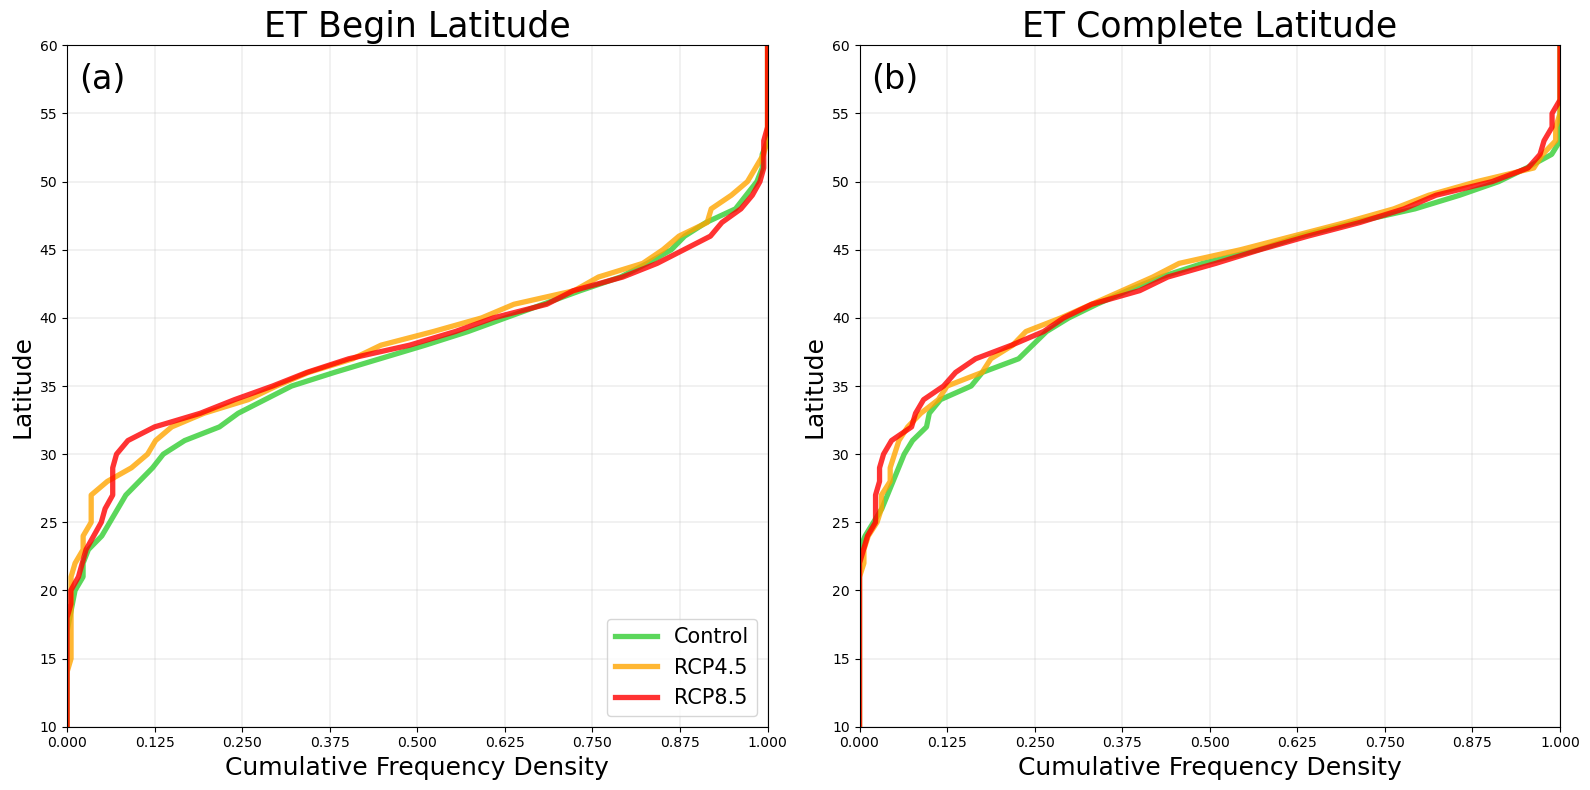

In [20]:
# ET Initiation and Completion Latitude
Var = "Lat"
Var_Label = "Latitude"
Horiz = True
Begin_Min, Compl_Min = 10, 10
Begin_Max, Compl_Max = 60, 60
Bin_Width, Label_Width = 1, 5
Savefig = True
Figname = 'ET_Latitude_Cumulative.png'
ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Horiz, \
Begin_Min, Compl_Min, Begin_Max, Compl_Max, Bin_Width, Label_Width, Savefig, Figname)

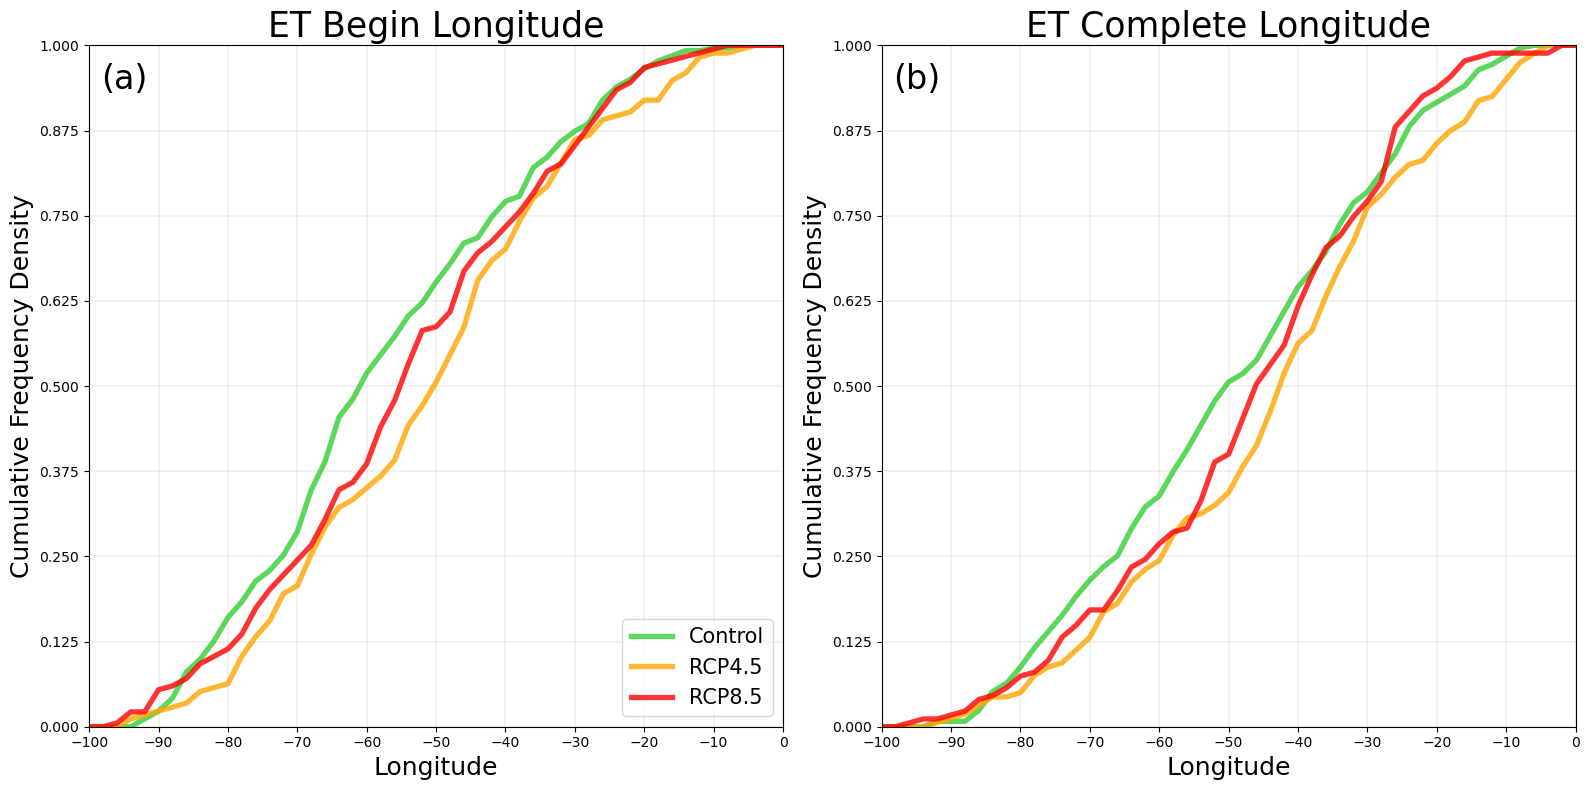

In [21]:
# ET Initiation and Completion Longitude
Var = "Lon"
Var_Label = "Longitude"
Horiz = False
Begin_Min, Compl_Min = -100, -100
Begin_Max, Compl_Max = 0, 0
Bin_Width, Label_Width = 2, 10
Savefig = True
Figname = 'ET_Longitude_Cumulative.png'
ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Horiz, \
Begin_Min, Compl_Min, Begin_Max, Compl_Max, Bin_Width, Label_Width, Savefig, Figname)

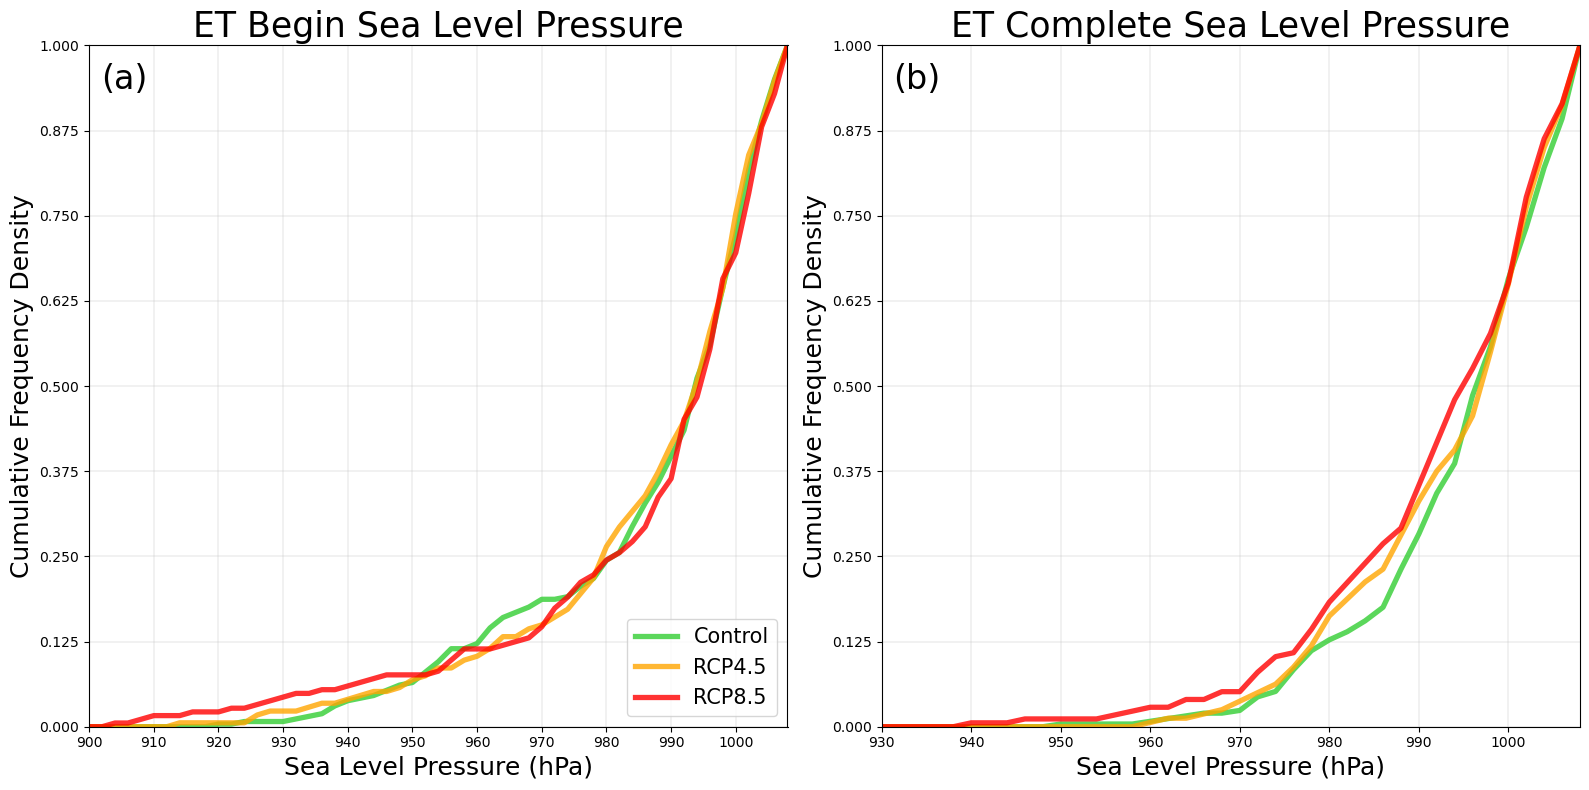

In [22]:
# ET Initiation and Completion Sea Level Pressure
Var = "SLP"
Var_Label = "Sea Level Pressure"
Horiz = False
Begin_Min, Compl_Min = 900, 930
Begin_Max, Compl_Max = 1008, 1008
Bin_Width, Label_Width = 2, 10
Savefig = True
Figname = 'ET_SLP_Cumulative.png'
ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Horiz, \
Begin_Min, Compl_Min, Begin_Max, Compl_Max, Bin_Width, Label_Width, Savefig, Figname)

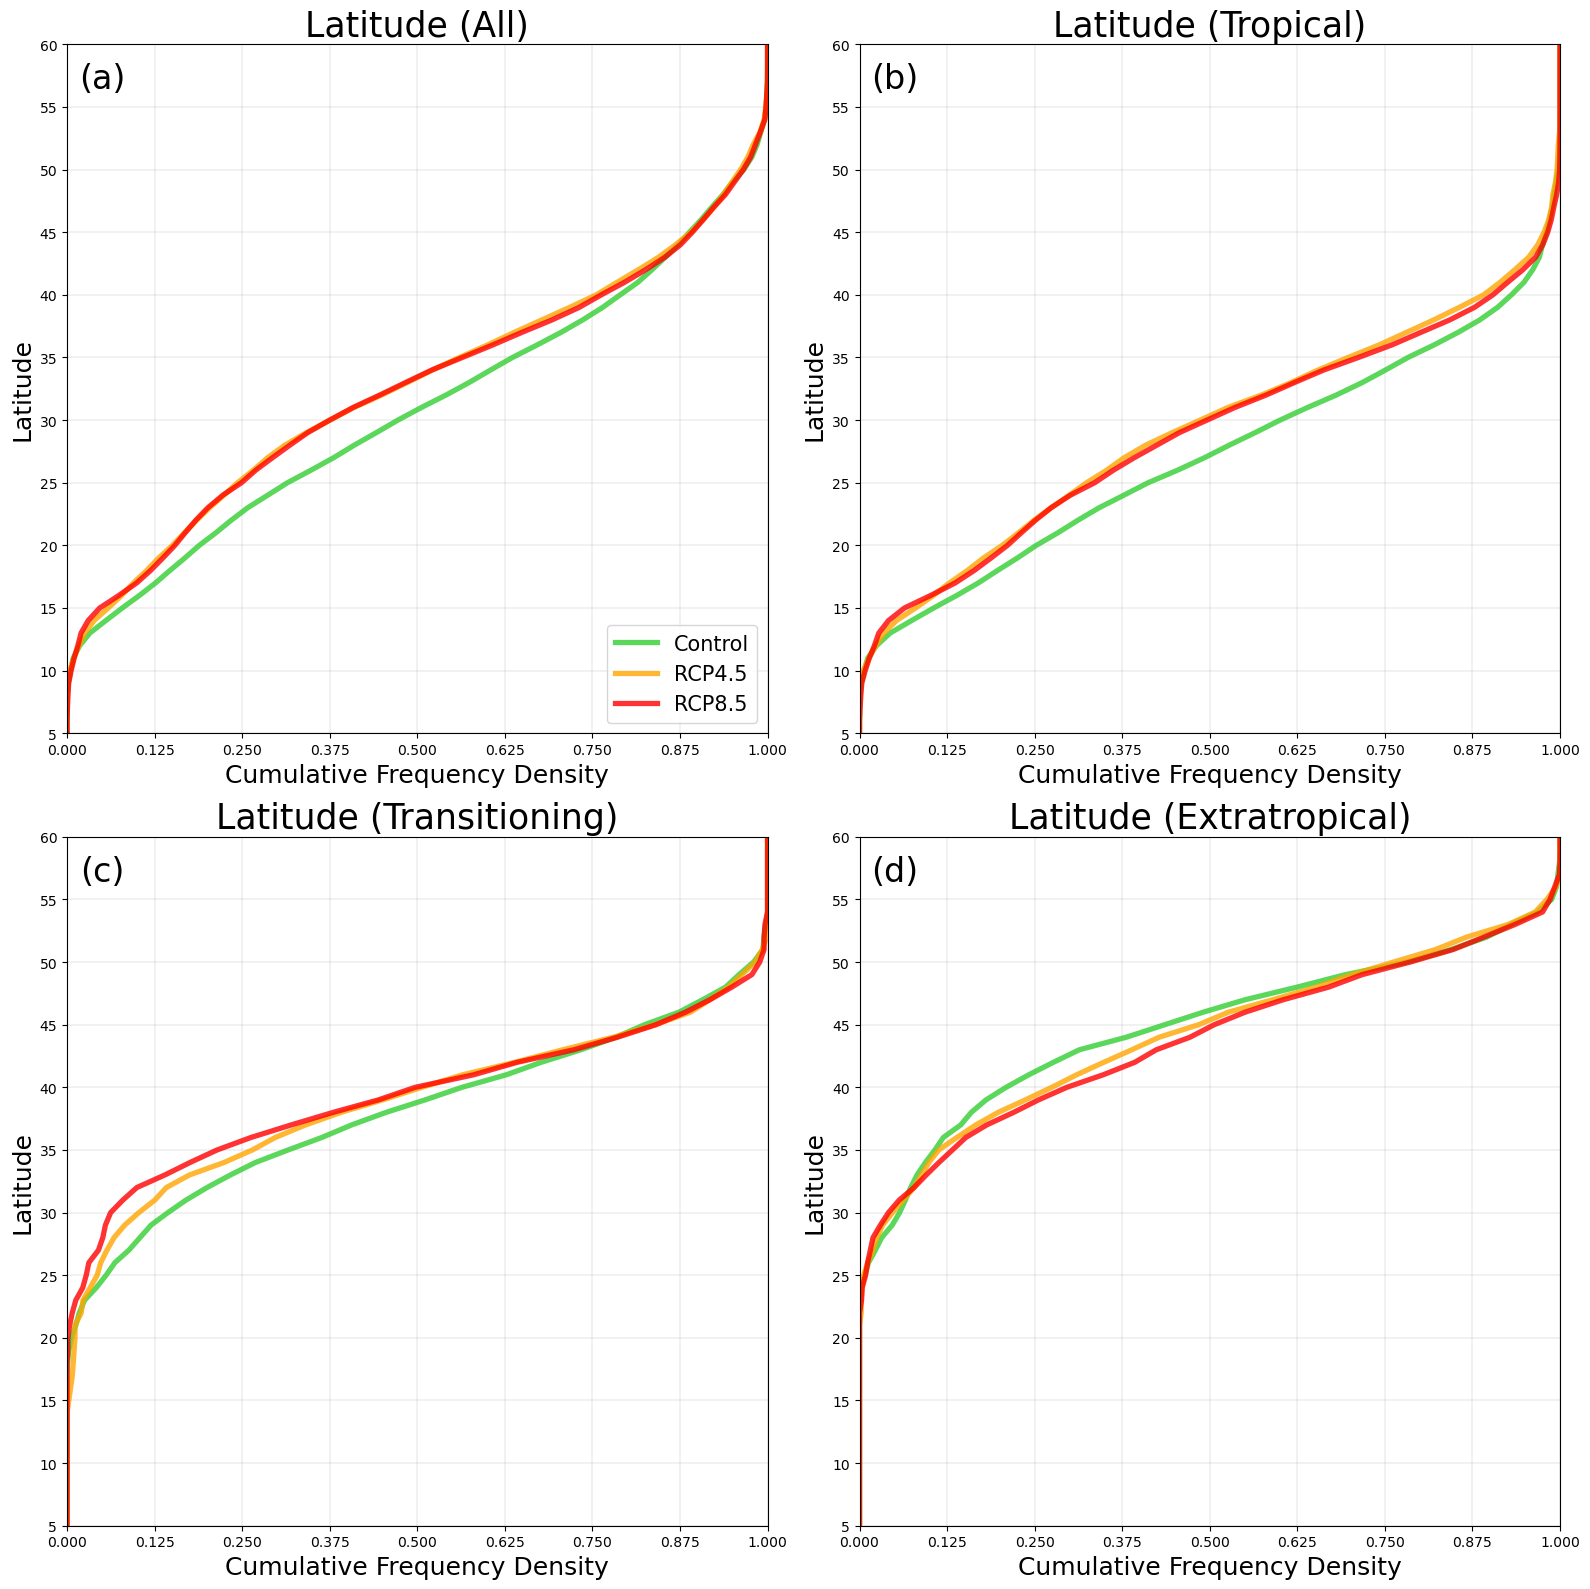

In [23]:
# Latitude in Each Storm Phase
Var = "Lat"
Var_Label = "Latitude"
Horiz = True
All_Min, Trop_Min, Trans_Min, Extra_Min = 5, 5, 5, 5
All_Max, Trop_Max, Trans_Max, Extra_Max = 60, 60, 60, 60
Bin_Width, Label_Width = 1, 5
Savefig = True
Figname = 'Phase_Latitude_Cumulative.png'
Phase_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Var, Var_Label, Horiz, \
All_Min, Trop_Min, Trans_Min, Extra_Min, All_Max, Trop_Max, Trans_Max, Extra_Max, \
Bin_Width, Label_Width, Savefig, Figname)

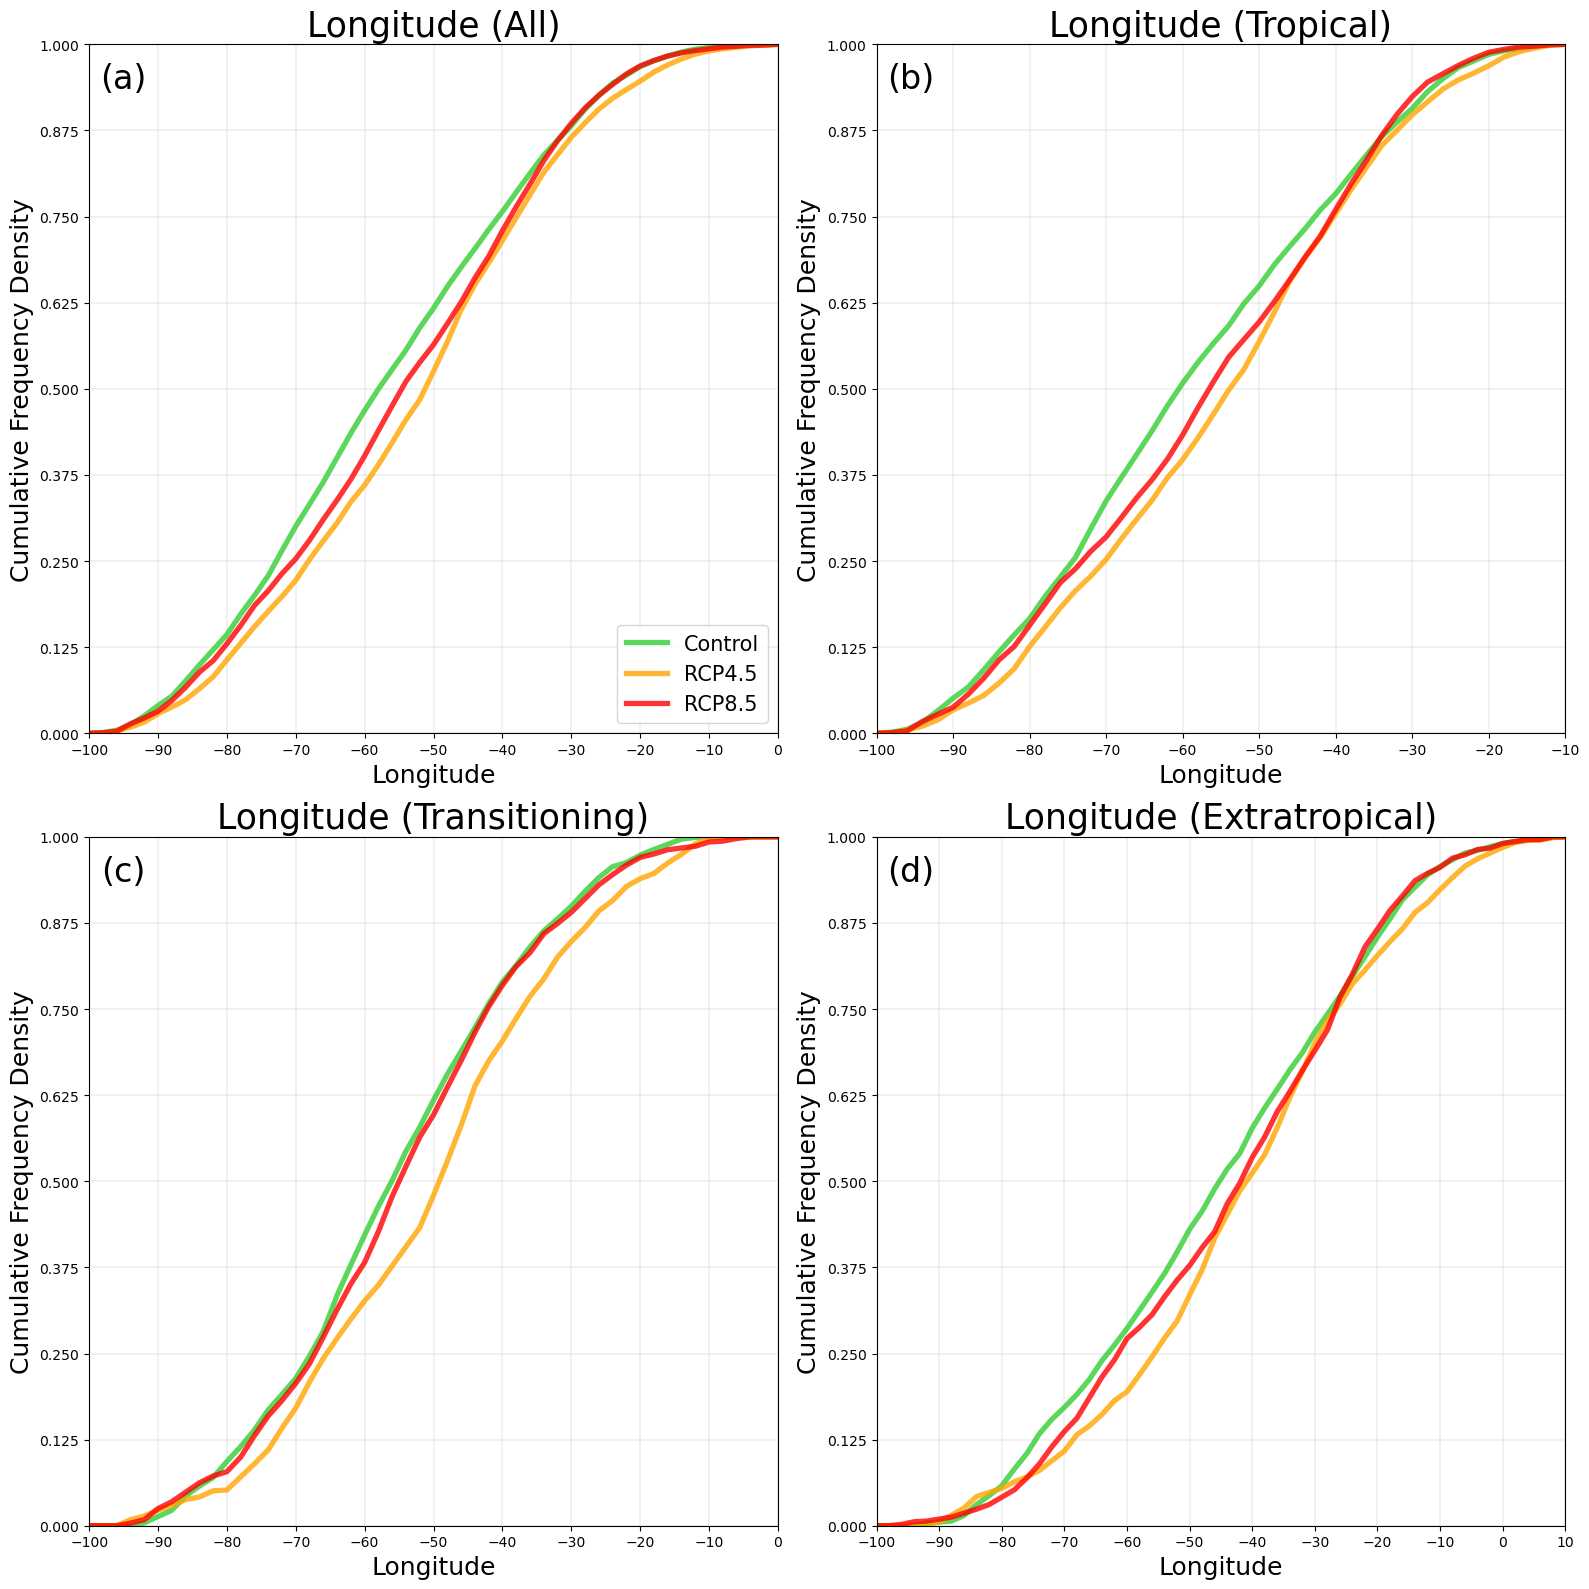

In [24]:
# Longitude in Each Storm Phase
Var = "Lon"
Var_Label = "Longitude"
Horiz = False
All_Min, Trop_Min, Trans_Min, Extra_Min = -100, -100, -100, -100
All_Max, Trop_Max, Trans_Max, Extra_Max = 0, -10, 0, 10
Bin_Width, Label_Width = 2, 10
Savefig = True
Figname = 'Phase_Longitude_Cumulative.png'
Phase_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Var, Var_Label, Horiz, \
All_Min, Trop_Min, Trans_Min, Extra_Min, All_Max, Trop_Max, Trans_Max, Extra_Max, \
Bin_Width, Label_Width, Savefig, Figname)

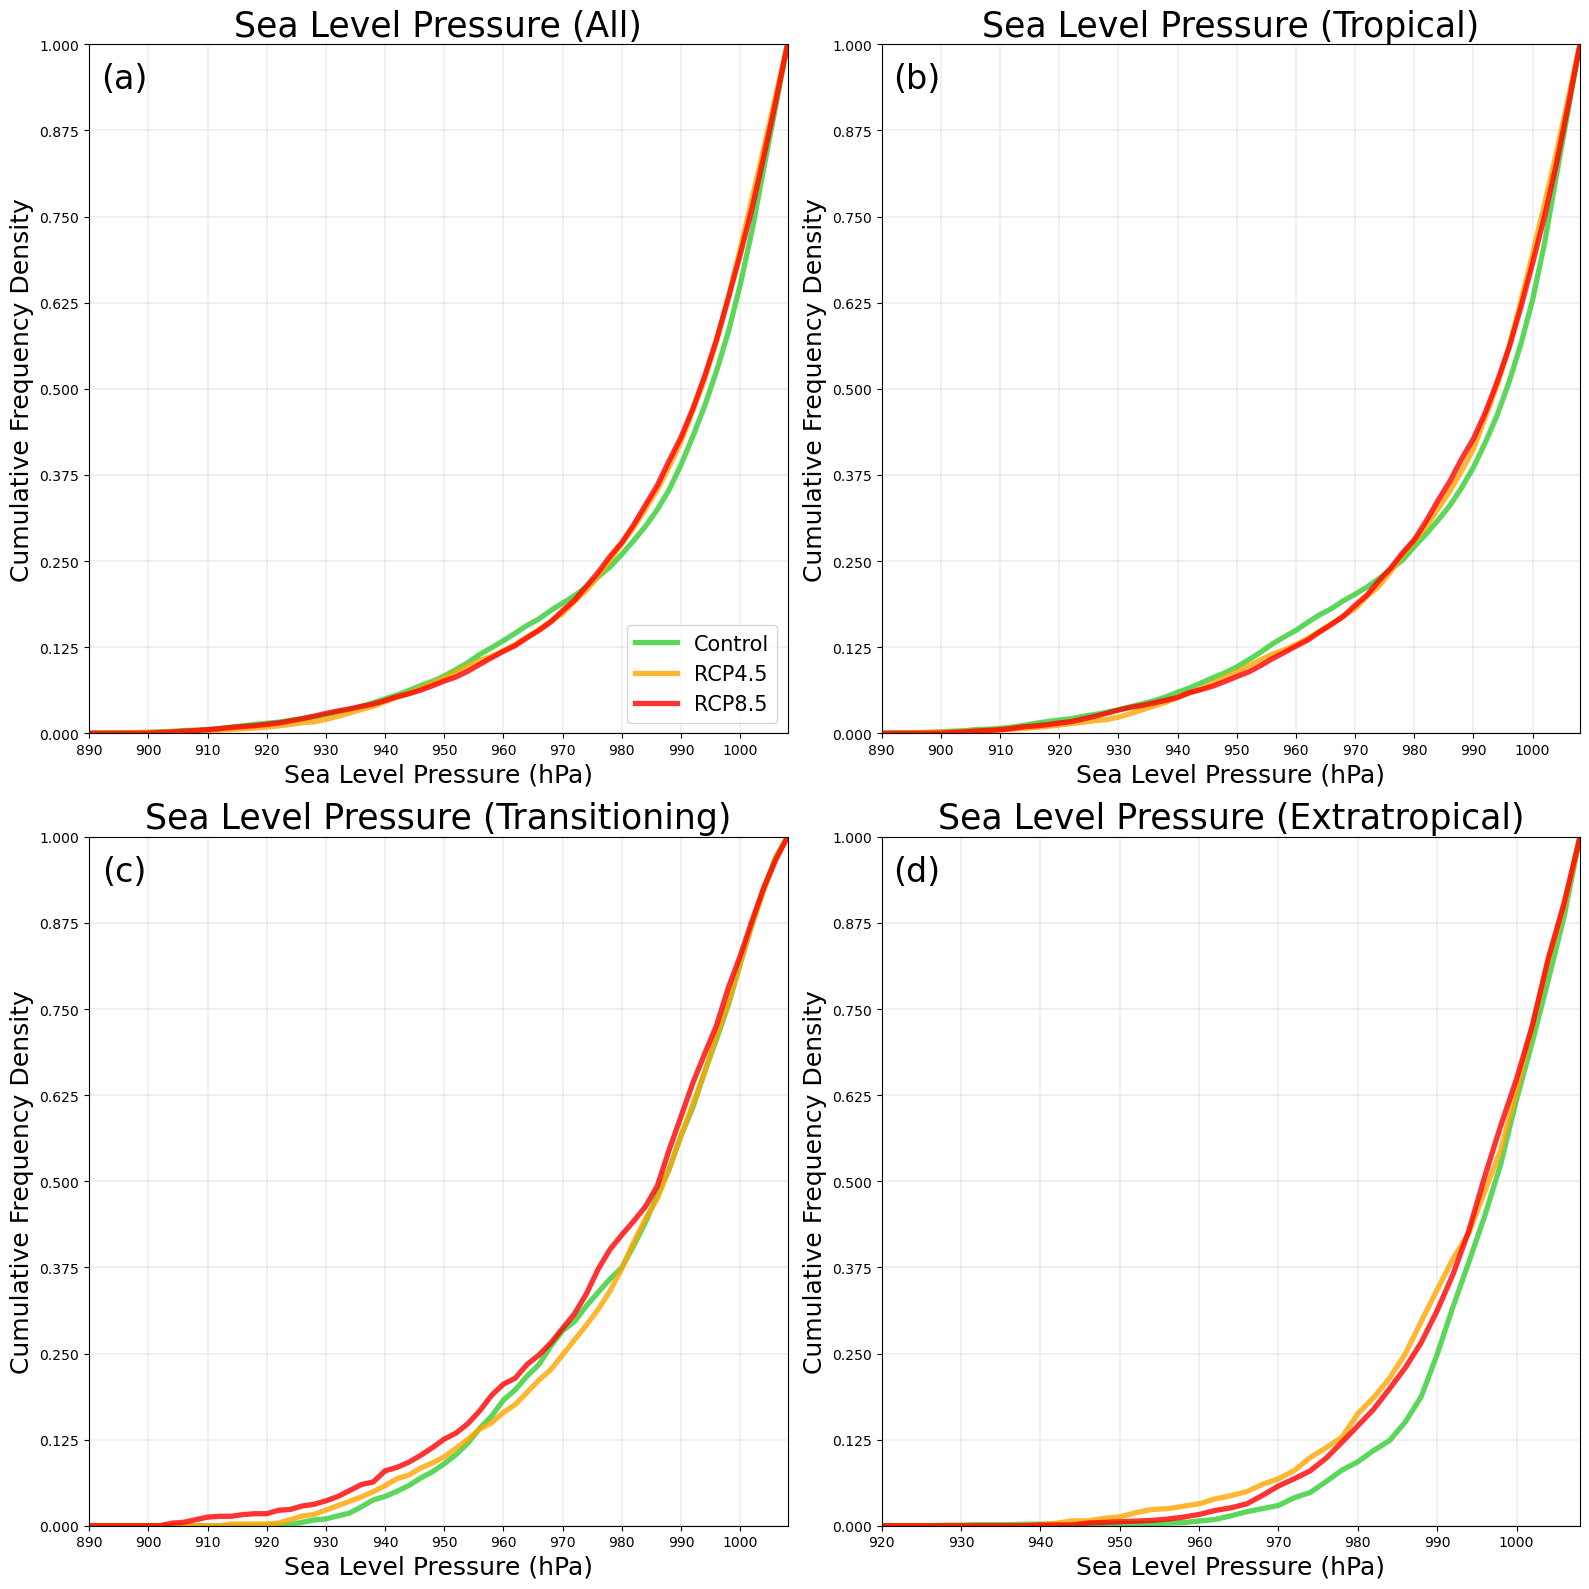

In [25]:
# Latitude in Each Storm Phase
Var = "SLP(hPa)"
Var_Label = "Sea Level Pressure"
Horiz = False
All_Min, Trop_Min, Trans_Min, Extra_Min = 890, 890, 890, 920
All_Max, Trop_Max, Trans_Max, Extra_Max = 1008, 1008, 1008, 1008
Bin_Width, Label_Width = 2, 10
Savefig = True
Figname = 'Phase_SLP_Cumulative.png'
Phase_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Var, Var_Label, Horiz, \
All_Min, Trop_Min, Trans_Min, Extra_Min, All_Max, Trop_Max, Trans_Max, Extra_Max, \
Bin_Width, Label_Width, Savefig, Figname)

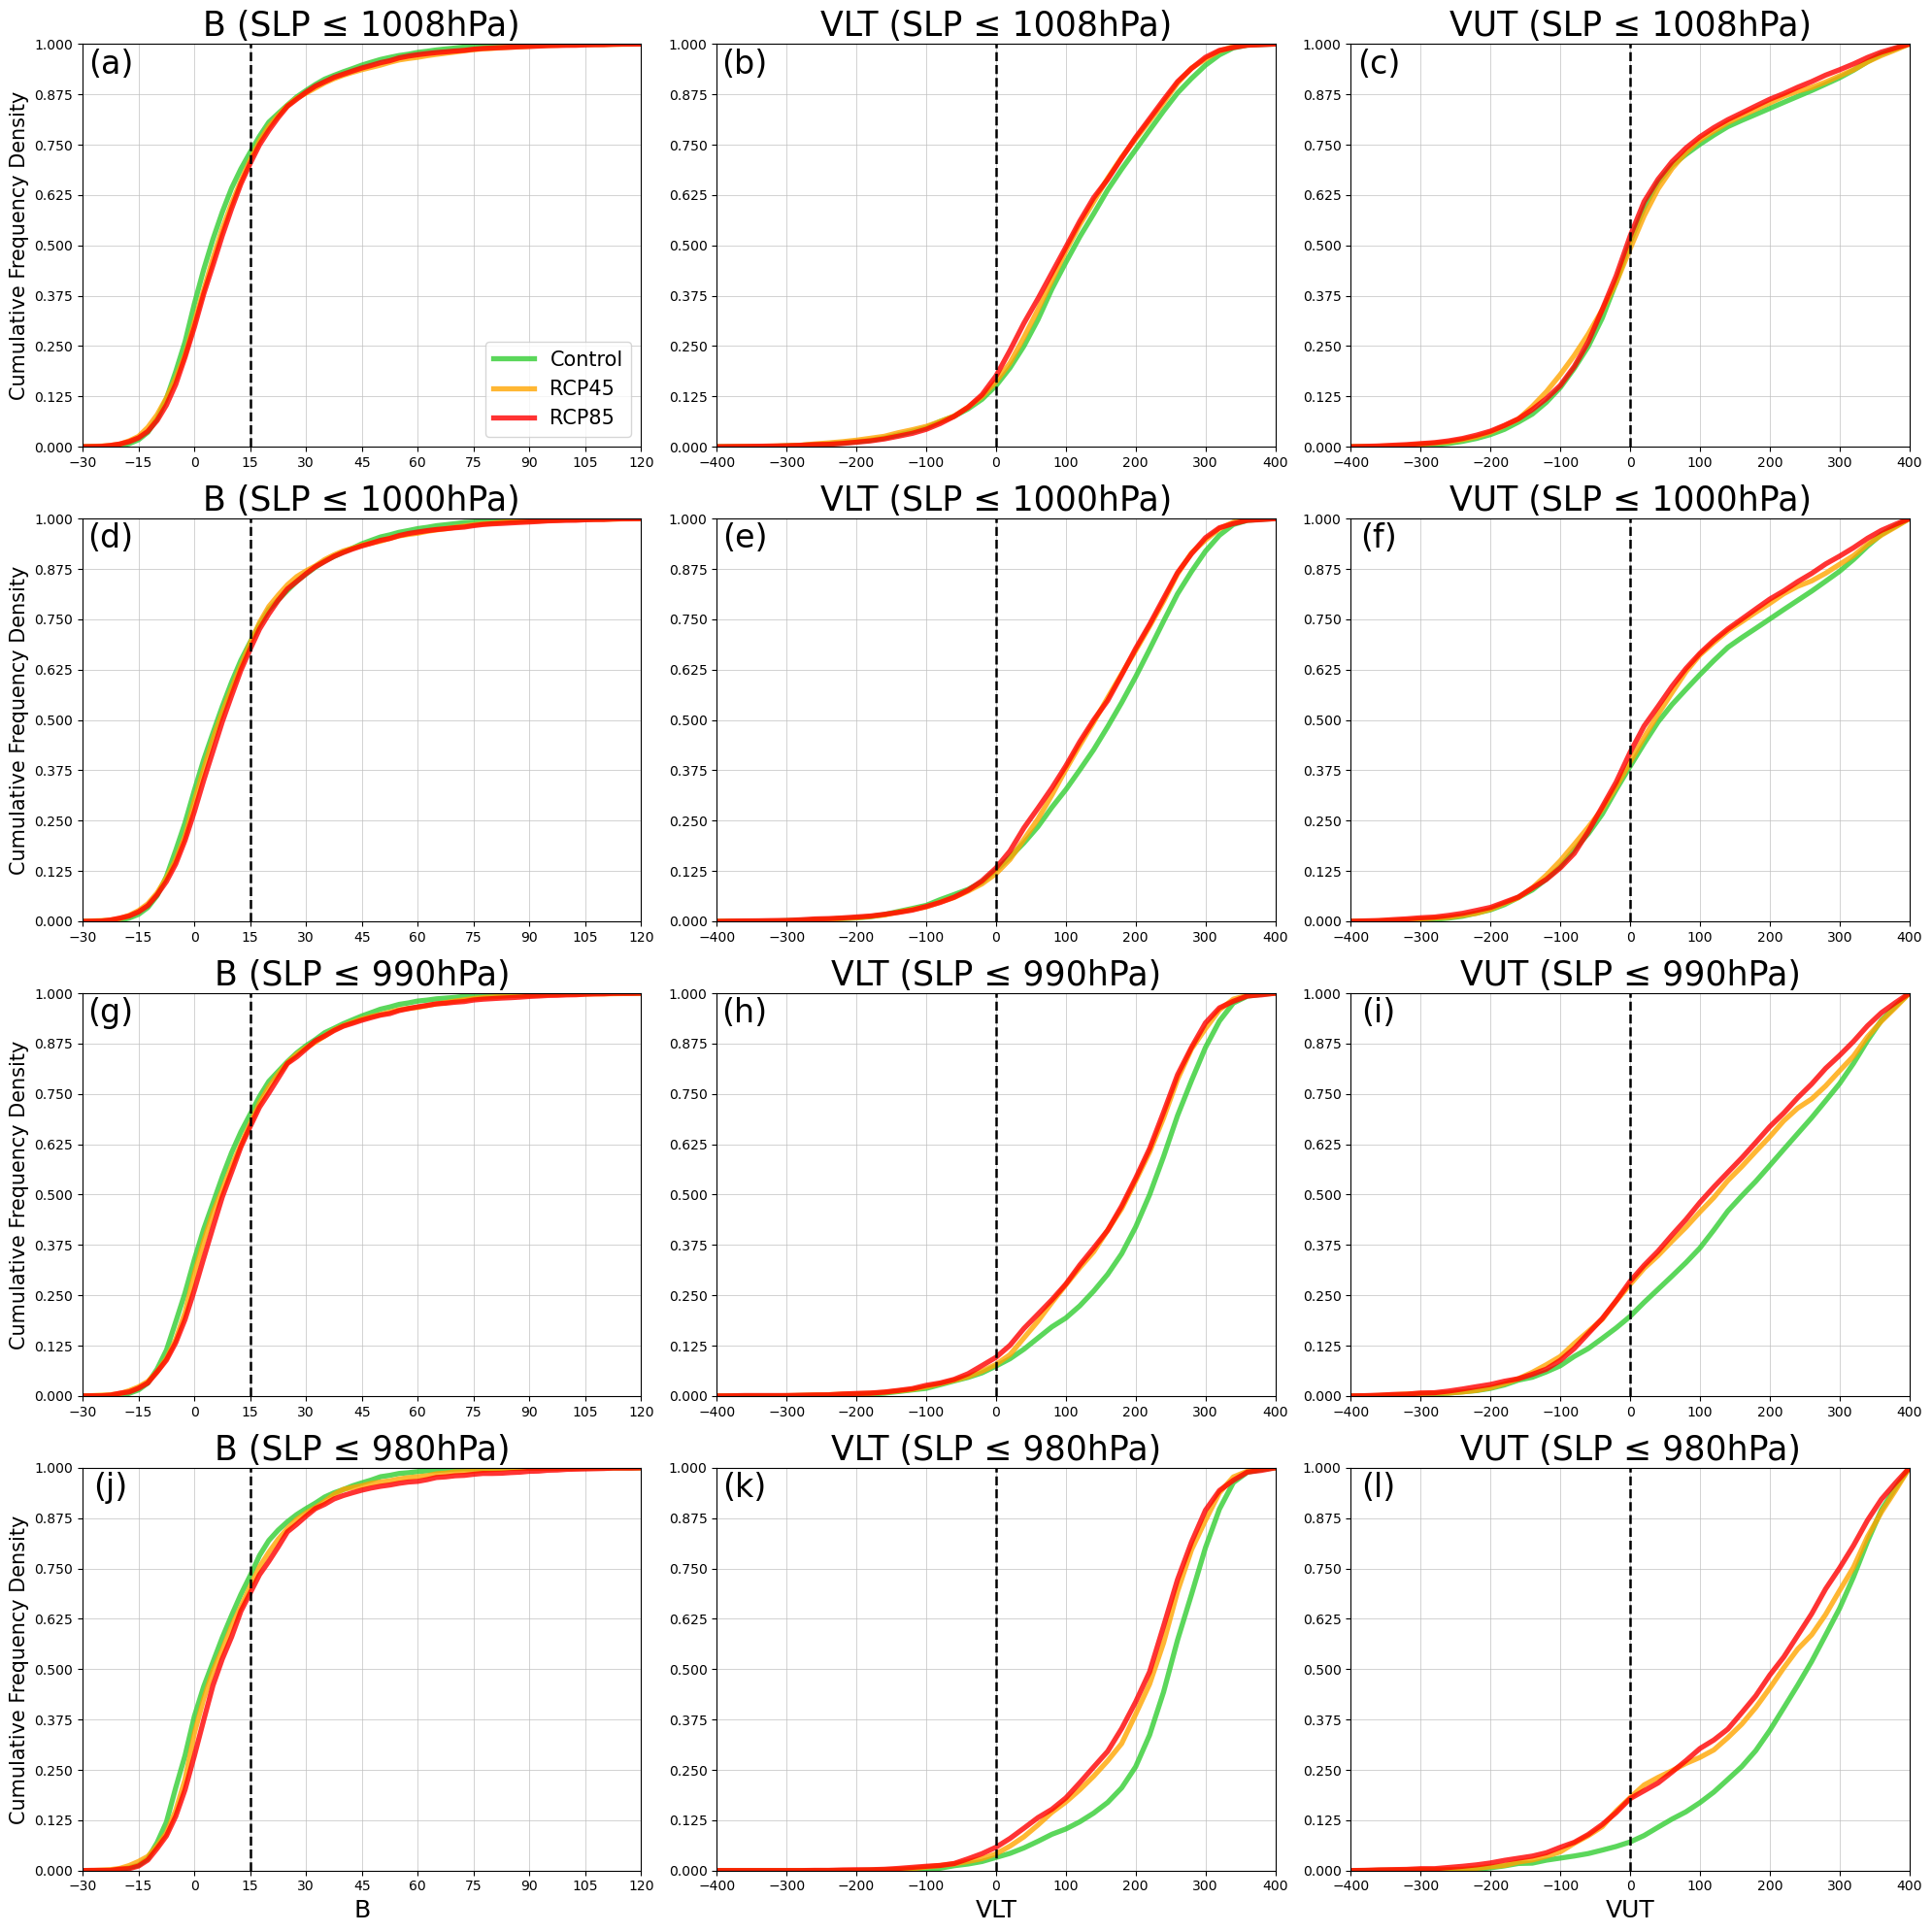

In [26]:
# B and VLT Values With Sea Level Pressure Subsets
Subset_Var = "SLP(hPa)"
B_Min, B_Max, B_Bin_Width, B_Label_Width = -30, 120, 2.5, 15
VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width = -400, 400, 20, 100
Savefig = True
Figname = 'Param_Subset_SLP_Cumulative.png'
Param_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Subset_Var, \
B_Min, B_Max, B_Bin_Width, B_Label_Width, VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width, Savefig, Figname)

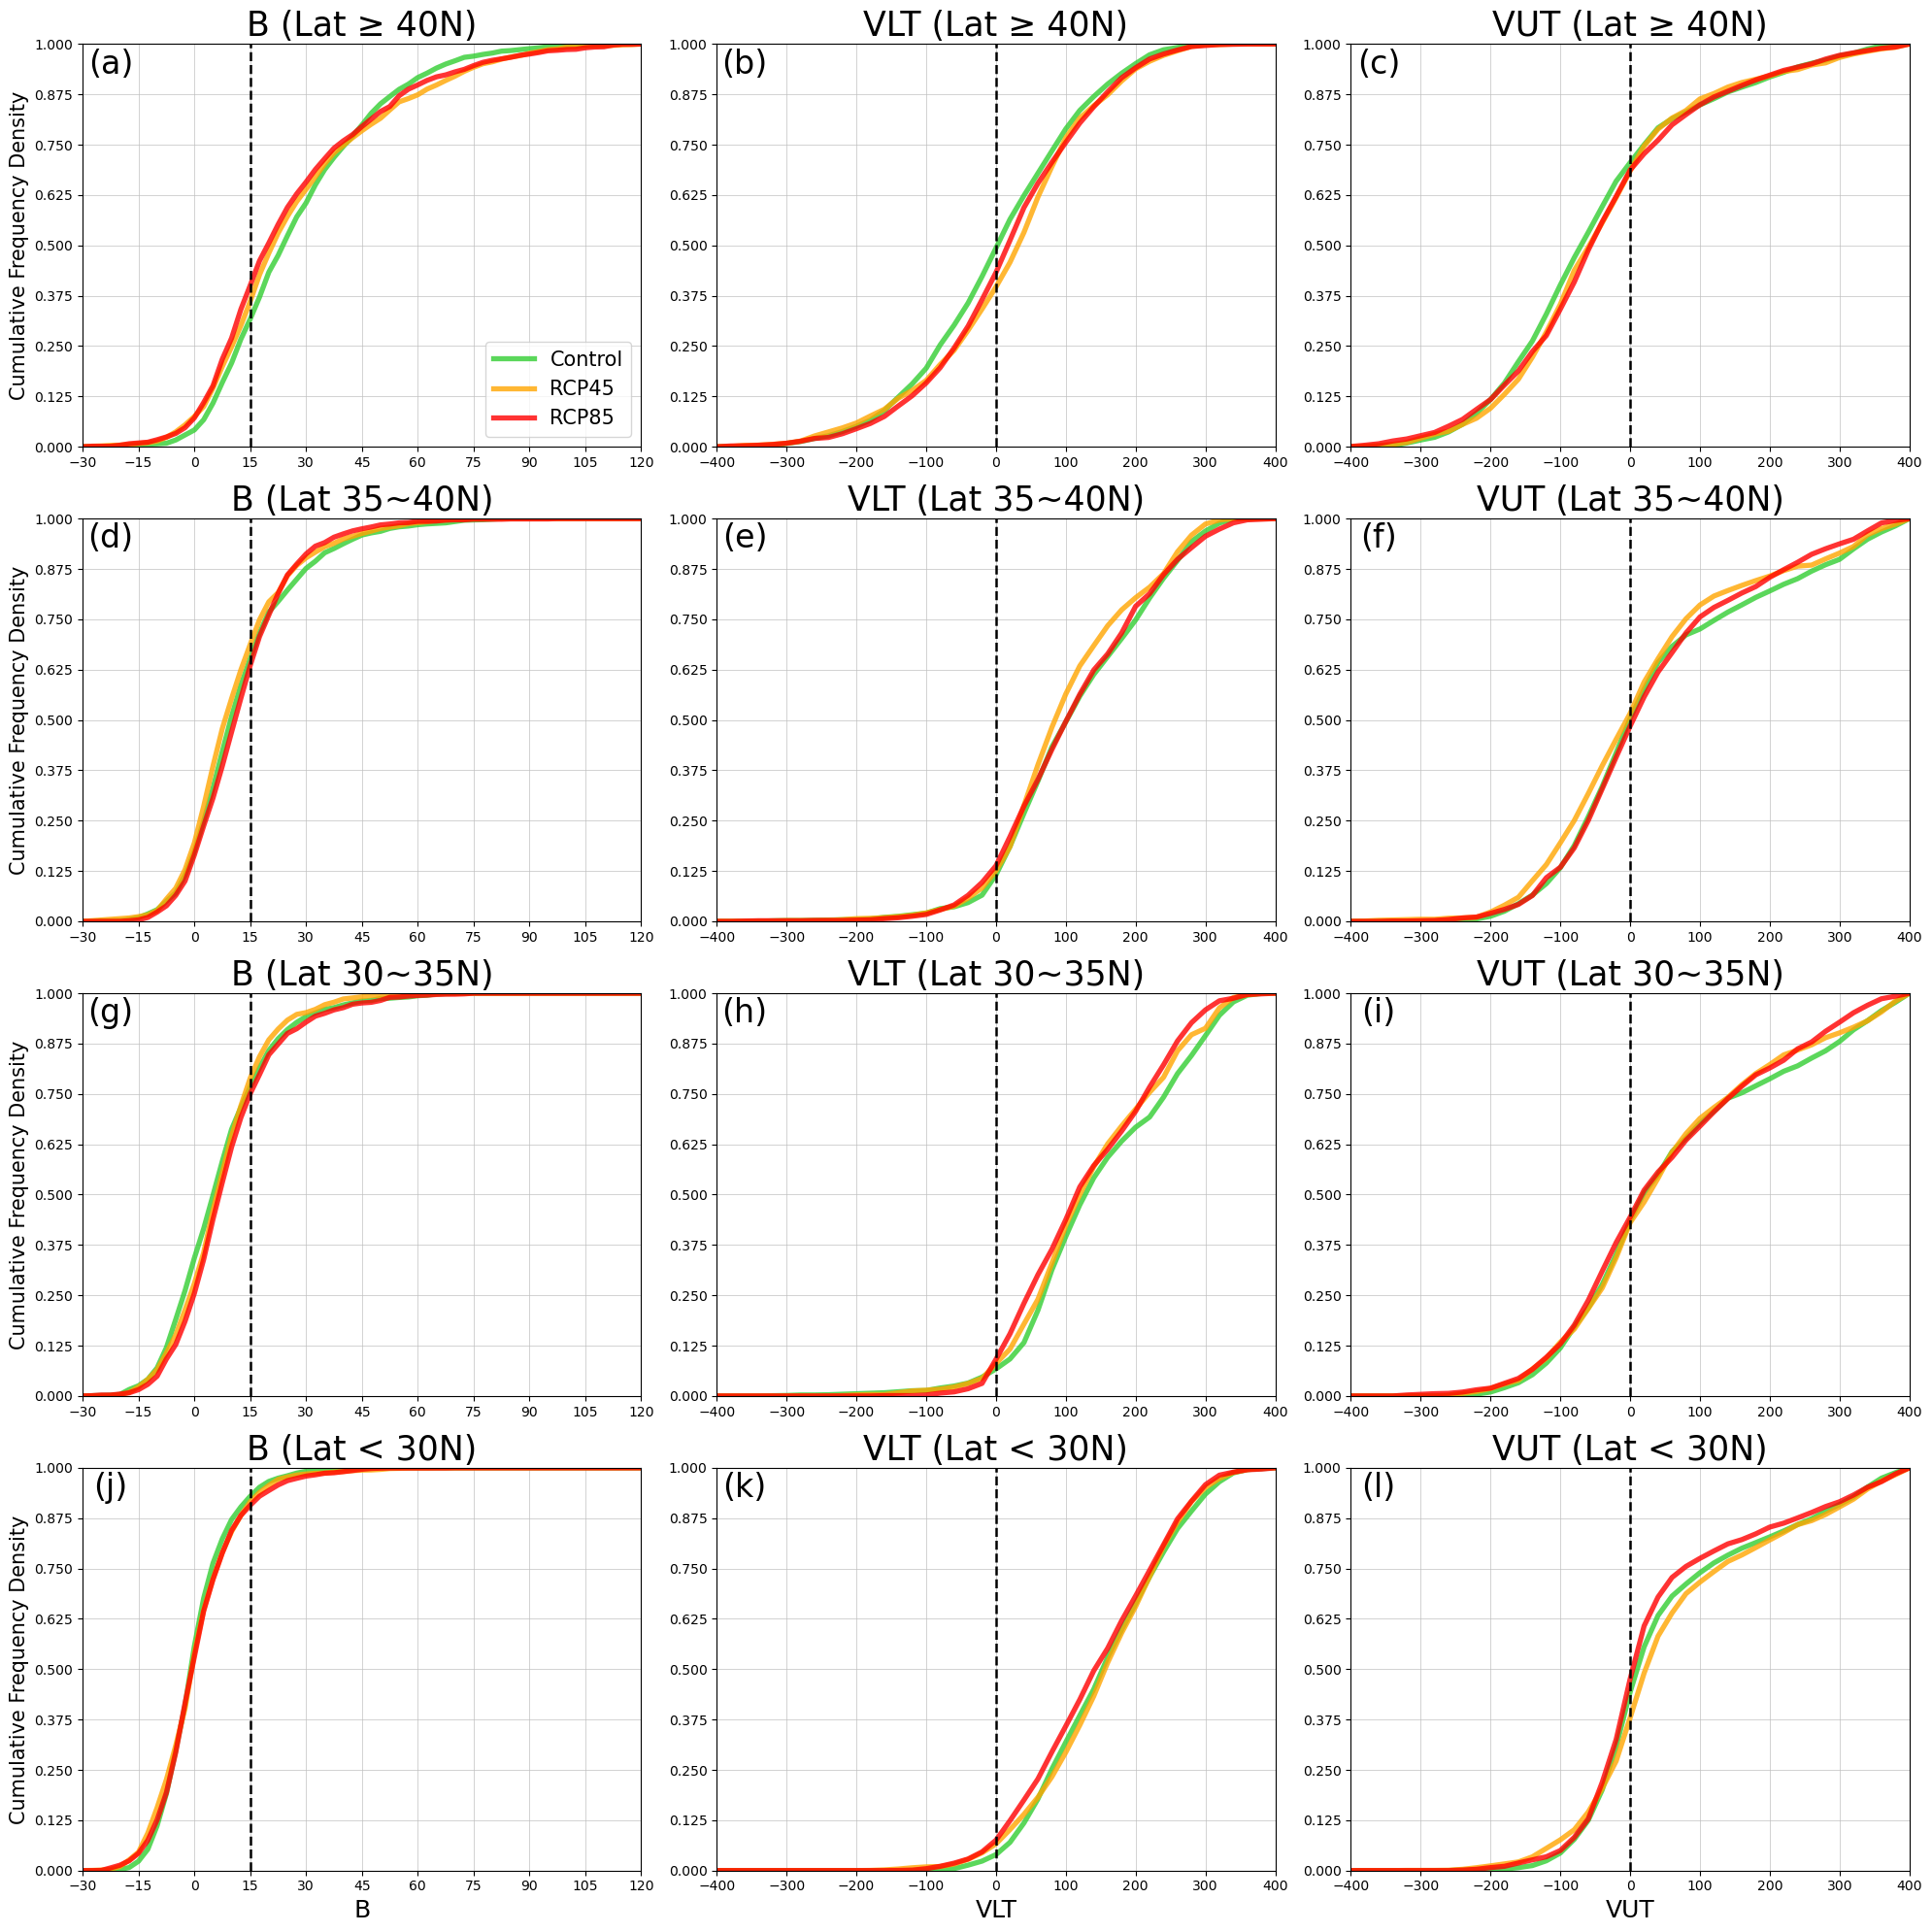

In [27]:
# B and VLT Values With Latitude Subsets
Subset_Var = "Lat"
B_Min, B_Max, B_Bin_Width, B_Label_Width = -30, 120, 2.5, 15
VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width = -400, 400, 20, 100
Savefig = True
Figname = 'Param_Subset_Lat_Cumulative.png'
Param_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Subset_Var, \
B_Min, B_Max, B_Bin_Width, B_Label_Width, VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width, Savefig, Figname)

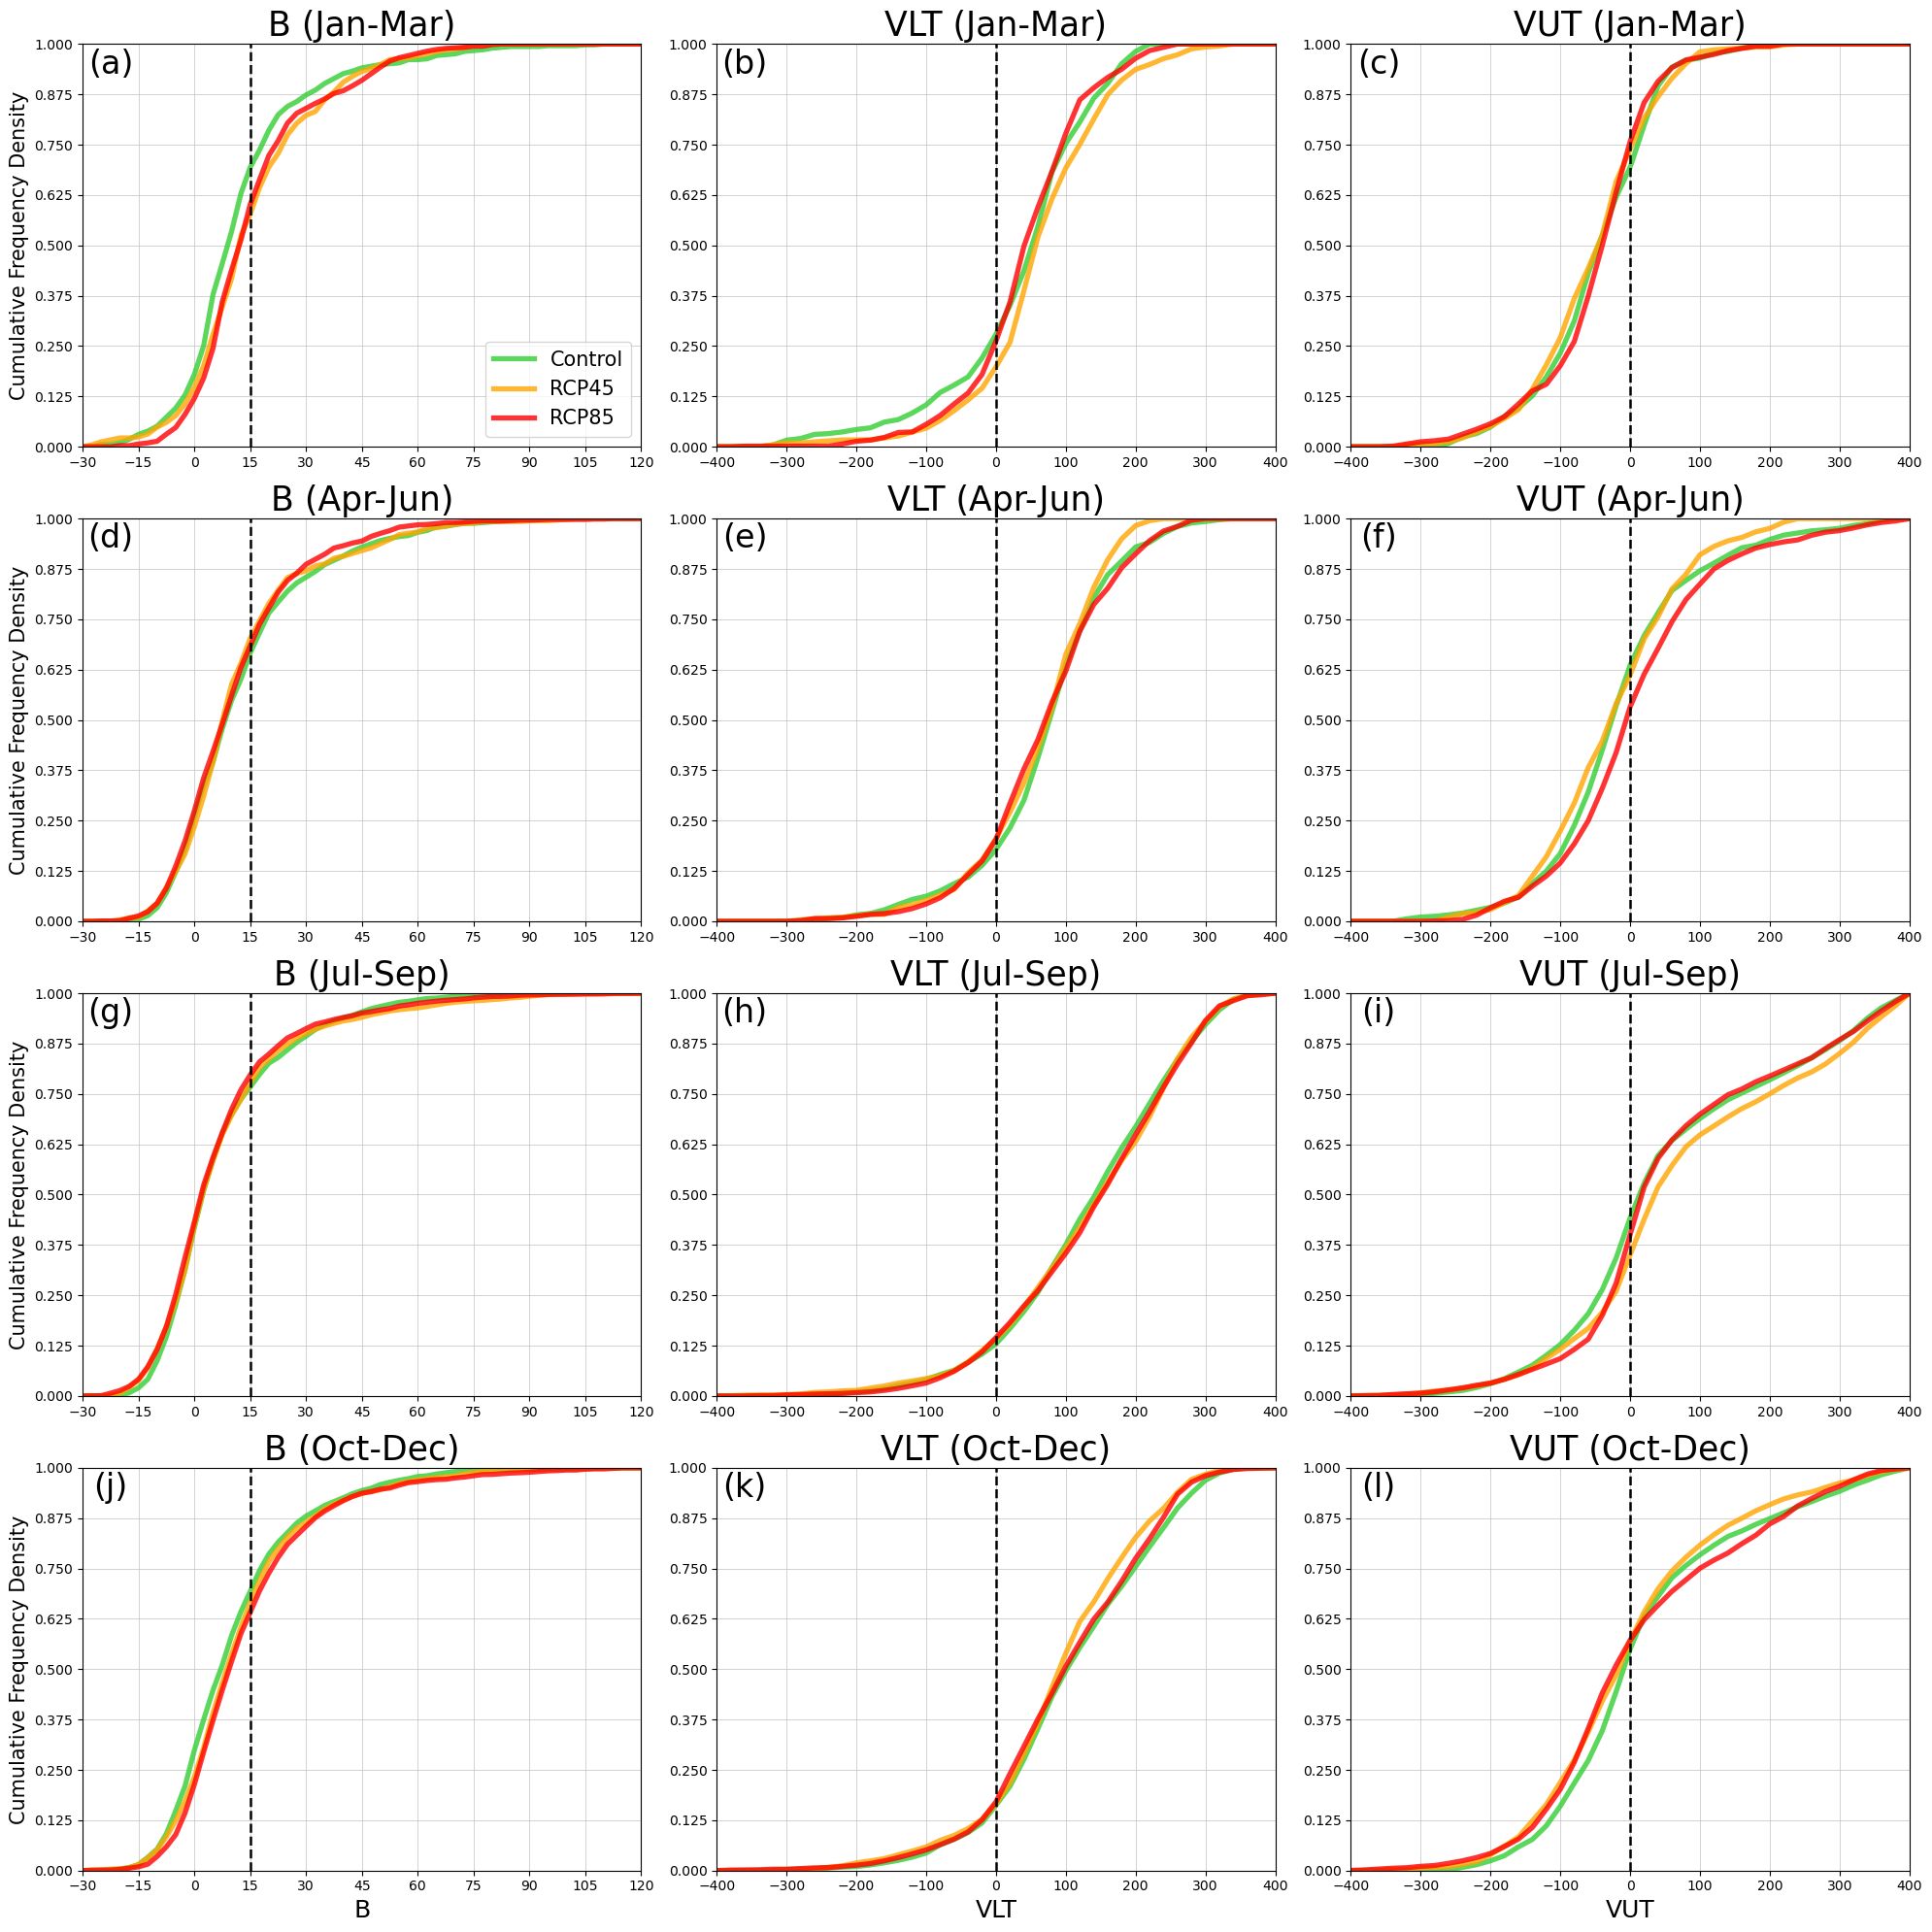

In [28]:
# B and VLT Values With Month Subsets
Subset_Var = "Month"
B_Min, B_Max, B_Bin_Width, B_Label_Width = -30, 120, 2.5, 15
VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width = -400, 400, 20, 100
Savefig = True
Figname = 'Param_Subset_Month_Cumulative.png'
Param_Cum_Dist_Plot(Control_Data, RCP45_Data, RCP85_Data, Subset_Var, \
B_Min, B_Max, B_Bin_Width, B_Label_Width, VLT_Min, VLT_Max, VLT_Bin_Width, VLT_Label_Width, Savefig, Figname)